In [32]:
pip install selenium beautifulsoup4 pandas webdriver-manager

In [33]:
import time
import os
import pandas as pd
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from webdriver_manager.chrome import ChromeDriverManager


# ---------------------------------
# CONFIGURATION
# ---------------------------------
CITIES = ["Mumbai", "Delhi", "Bangalore", "Goa", "Jaipur"]

CHECKIN_DATE = "2026-02-20"
CHECKOUT_DATE = "2026-02-21"

BASE_URL = "https://www.booking.com/searchresults.html"
OUTPUT_PATH = "data/raw/booking_hotels_raw.csv"


# ---------------------------------
# SET UP CHROME DRIVER
# ---------------------------------
chrome_options = Options()

# 🔍 FIRST RUN: keep headless OFF
# chrome_options.add_argument("--headless")

chrome_options.add_argument("--window-size=1920,1080")
chrome_options.add_argument("--disable-blink-features=AutomationControlled")

driver = webdriver.Chrome(
    service=Service(ChromeDriverManager().install()),
    options=chrome_options
)

wait = WebDriverWait(driver, 25)


# ---------------------------------
# COOKIE HANDLER
# ---------------------------------
def handle_cookies():
    try:
        cookie_btn = WebDriverWait(driver, 5).until(
            EC.element_to_be_clickable(
                (By.ID, "onetrust-accept-btn-handler")
            )
        )
        cookie_btn.click()
        time.sleep(2)
    except:
        pass


# ---------------------------------
# SCRAPE ONE CITY
# ---------------------------------
def scrape_city(city):
    hotels = []

    for offset in [0, 25]:
        params = (
            f"?ss={city}"
            f"&checkin={CHECKIN_DATE}"
            f"&checkout={CHECKOUT_DATE}"
            f"&group_adults=2"
            f"&no_rooms=1"
            f"&offset={offset}"
        )

        url = BASE_URL + params
        driver.get(url)
        handle_cookies()

        try:
            wait.until(
                EC.any_of(
                    EC.presence_of_element_located(
                        (By.CSS_SELECTOR, "div[data-testid='property-card']")
                    ),
                    EC.presence_of_element_located(
                        (By.CSS_SELECTOR, "div[data-testid='title']")
                    )
                )
            )
        except:
            print(f"⚠️ No hotels loaded for {city} at offset {offset}")
            continue

        soup = BeautifulSoup(driver.page_source, "html.parser")
        cards = soup.select("div[data-testid='property-card']")

        for card in cards:
            try:
                name = card.select_one("div[data-testid='title']").get_text(strip=True)
            except:
                name = None

            try:
                price = card.select_one(
                    "span[data-testid='price-and-discounted-price']"
                ).get_text(strip=True)
            except:
                price = None

            try:
                rating = card.select_one(
                    "div[data-testid='review-score']"
                ).get_text(strip=True)
            except:
                rating = None

            try:
                reviews = card.select_one(
                    "div[data-testid='review-score'] div:nth-child(2)"
                ).get_text(strip=True)
            except:
                reviews = None

            try:
                property_type = card.select_one(
                    "span[data-testid='property-type']"
                ).get_text(strip=True)
            except:
                property_type = None

            hotels.append({
                "city": city,
                "hotel_name": name,
                "price_raw": price,
                "rating_raw": rating,
                "reviews_raw": reviews,
                "property_type": property_type
            })

        time.sleep(3)

    return hotels


# ---------------------------------
# MAIN EXECUTION
# ---------------------------------
all_hotels = []

for city in CITIES:
    print(f"Scraping {city}...")
    city_hotels = scrape_city(city)
    all_hotels.extend(city_hotels)

driver.quit()

df = pd.DataFrame(all_hotels)

# ✅ CREATE LOCAL FOLDER SAFELY
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

df.to_csv(OUTPUT_PATH, index=False)

print("✅ Scraping completed. Raw data saved.")

Scraping Mumbai...
Scraping Delhi...
Scraping Bangalore...
Scraping Goa...
Scraping Jaipur...
✅ Scraping completed. Raw data saved.


In [34]:
import pandas as pd
import numpy as np
import re

df = pd.read_csv("data/raw/booking_hotels_raw.csv")

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   city           264 non-null    object 
 1   hotel_name     264 non-null    object 
 2   price_raw      264 non-null    object 
 3   rating_raw     262 non-null    object 
 4   reviews_raw    262 non-null    float64
 5   property_type  0 non-null      float64
dtypes: float64(2), object(4)
memory usage: 12.5+ KB


In [35]:
import pandas as pd
import numpy as np
import re

df = pd.read_csv("data/raw/booking_hotels_raw.csv")

In [36]:
df 

,city,hotel_name,price_raw,rating_raw,reviews_raw,property_type
0,Mumbai,Hilton Garden Inn Mumbai International Airport,"₹ 10,007",Scored 8.38.3Very Good308 reviews,8.3,NaN
1,Mumbai,Fairmont Mumbai,"₹ 27,500",Scored 9.09.0Wonderful403 reviews,9.0,NaN
2,Mumbai,Hotel Bawa International,"₹ 6,750",Scored 7.67.6Good759 reviews,7.6,NaN
3,Mumbai,Hilton Mumbai International Airport Hotel,"₹ 19,700","Scored 8.78.7Excellent2,445 reviews",8.7,NaN
4,Mumbai,Ginger Mumbai Airport,"₹ 7,999","Scored 7.37.3Good1,712 reviews",7.3,NaN
...,...,...,...,...,...,...
259,Jaipur,The Sunder Palace-Jaipur City Centre Hotel,"₹ 6,960",Scored 8.48.4Very Good41 reviews,8.4,NaN
260,Jaipur,Laxmi Palace Heritage Boutique Hotel,"₹ 6,435","Scored 8.38.3Very Good1,576 reviews",8.3,NaN
261,Jaipur,ASHOK VILLA,"₹ 4,500",Scored 9.29.2Wonderful669 reviews,9.2,NaN
262,Jaipur,Villa Bonita- Luxury Farm Stay Jaipur,"₹ 11,098",NaN,NaN,NaN


In [37]:
df = df.drop(columns=["property_type"])

In [38]:
df

,city,hotel_name,price_raw,rating_raw,reviews_raw
0,Mumbai,Hilton Garden Inn Mumbai International Airport,"₹ 10,007",Scored 8.38.3Very Good308 reviews,8.3
1,Mumbai,Fairmont Mumbai,"₹ 27,500",Scored 9.09.0Wonderful403 reviews,9.0
2,Mumbai,Hotel Bawa International,"₹ 6,750",Scored 7.67.6Good759 reviews,7.6
3,Mumbai,Hilton Mumbai International Airport Hotel,"₹ 19,700","Scored 8.78.7Excellent2,445 reviews",8.7
4,Mumbai,Ginger Mumbai Airport,"₹ 7,999","Scored 7.37.3Good1,712 reviews",7.3
...,...,...,...,...,...
259,Jaipur,The Sunder Palace-Jaipur City Centre Hotel,"₹ 6,960",Scored 8.48.4Very Good41 reviews,8.4
260,Jaipur,Laxmi Palace Heritage Boutique Hotel,"₹ 6,435","Scored 8.38.3Very Good1,576 reviews",8.3
261,Jaipur,ASHOK VILLA,"₹ 4,500",Scored 9.29.2Wonderful669 reviews,9.2
262,Jaipur,Villa Bonita- Luxury Farm Stay Jaipur,"₹ 11,098",NaN,NaN


In [39]:
# Clean price
def clean_price(price):
    price = re.sub(r"[^\d]", "", str(price))
    return float(price) if price else np.nan

df["price"] = df["price_raw"].apply(clean_price)

In [40]:
# Clean rating
def clean_rating(rating):
    match = re.search(r"\d+\.?\d*", str(rating))
    return float(match.group()) if match else np.nan

df["rating"] = df["rating_raw"].apply(clean_rating)

In [41]:
# Handle reviews column
df = df.drop(columns=["reviews_raw"])

In [42]:
# Drop rows with missing price
df = df.dropna(subset=["price"])

In [43]:
# Remove duplicates
df = df.drop_duplicates(subset=["city", "hotel_name", "price"])

In [44]:
# Feature Engineering 
# Price category
def price_category(price):
    if price < 3000:
        return "Budget"
    elif price < 7000:
        return "Mid-range"
    else:
        return "Premium"

df["price_category"] = df["price"].apply(price_category)

In [45]:
# Rating bucket
def rating_bucket(r):
    if pd.isna(r):
        return "No rating"
    elif r >= 8.5:
        return "High"
    elif r >= 7:
        return "Medium"
    else:
        return "Low"

df["rating_bucket"] = df["rating"].apply(rating_bucket)

In [46]:
# Price per rating
df["price_per_rating"] = df["price"] / df["rating"]

In [47]:
# Final dataset
final_df = df[
    [
        "city",
        "hotel_name",
        "price",
        "price_category",
        "rating",
        "rating_bucket",
        "price_per_rating"
    ]
]

In [48]:
import os
os.makedirs("data/cleaned", exist_ok=True)

final_df.to_csv("data/cleaned/booking_hotels_clean.csv", index=False)

In [49]:
final_df.info()
final_df.head()
final_df["city"].value_counts()
final_df["price_category"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, 0 to 237
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              132 non-null    object 
 1   hotel_name        132 non-null    object 
 2   price             132 non-null    float64
 3   price_category    132 non-null    object 
 4   rating            131 non-null    float64
 5   rating_bucket     132 non-null    object 
 6   price_per_rating  131 non-null    float64
dtypes: float64(3), object(4)
memory usage: 8.2+ KB


price_category
Mid-range    52
Premium      40
Budget       40
Name: count, dtype: int64

In [50]:
df

,city,hotel_name,price_raw,rating_raw,price,rating,price_category,rating_bucket,price_per_rating
0,Mumbai,Hilton Garden Inn Mumbai International Airport,"₹ 10,007",Scored 8.38.3Very Good308 reviews,10007.0,8.38,Premium,Medium,1194.152745
1,Mumbai,Fairmont Mumbai,"₹ 27,500",Scored 9.09.0Wonderful403 reviews,27500.0,9.09,Premium,High,3025.302530
2,Mumbai,Hotel Bawa International,"₹ 6,750",Scored 7.67.6Good759 reviews,6750.0,7.67,Mid-range,Medium,880.052151
3,Mumbai,Hilton Mumbai International Airport Hotel,"₹ 19,700","Scored 8.78.7Excellent2,445 reviews",19700.0,8.78,Premium,High,2243.735763
4,Mumbai,Ginger Mumbai Airport,"₹ 7,999","Scored 7.37.3Good1,712 reviews",7999.0,7.37,Premium,Medium,1085.345997
...,...,...,...,...,...,...,...,...,...
233,Jaipur,The Sunder Palace-Jaipur City Centre Hotel,"₹ 6,960",Scored 8.48.4Very Good41 reviews,6960.0,8.48,Mid-range,Medium,820.754717
234,Jaipur,Laxmi Palace Heritage Boutique Hotel,"₹ 6,435","Scored 8.38.3Very Good1,576 reviews",6435.0,8.38,Mid-range,Medium,767.899761
235,Jaipur,ASHOK VILLA,"₹ 4,500",Scored 9.29.2Wonderful669 reviews,4500.0,9.29,Mid-range,High,484.391819
236,Jaipur,Dera Rawatsar - Heritage Hotel,"₹ 8,100",Scored 9.29.2Wonderful746 reviews,8100.0,9.29,Premium,High,871.905274


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/cleaned/booking_hotels_clean.csv")

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

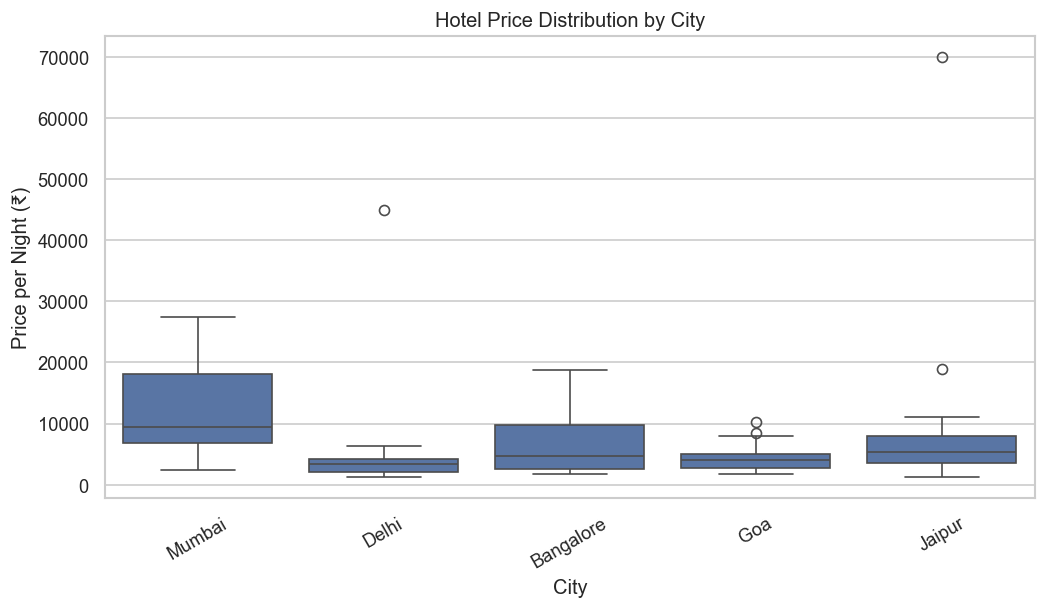

In [52]:
# City-wise Price Comparison
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="city", y="price")
plt.title("Hotel Price Distribution by City")
plt.xlabel("City")
plt.ylabel("Price per Night (₹)")
plt.xticks(rotation=30)
plt.show()

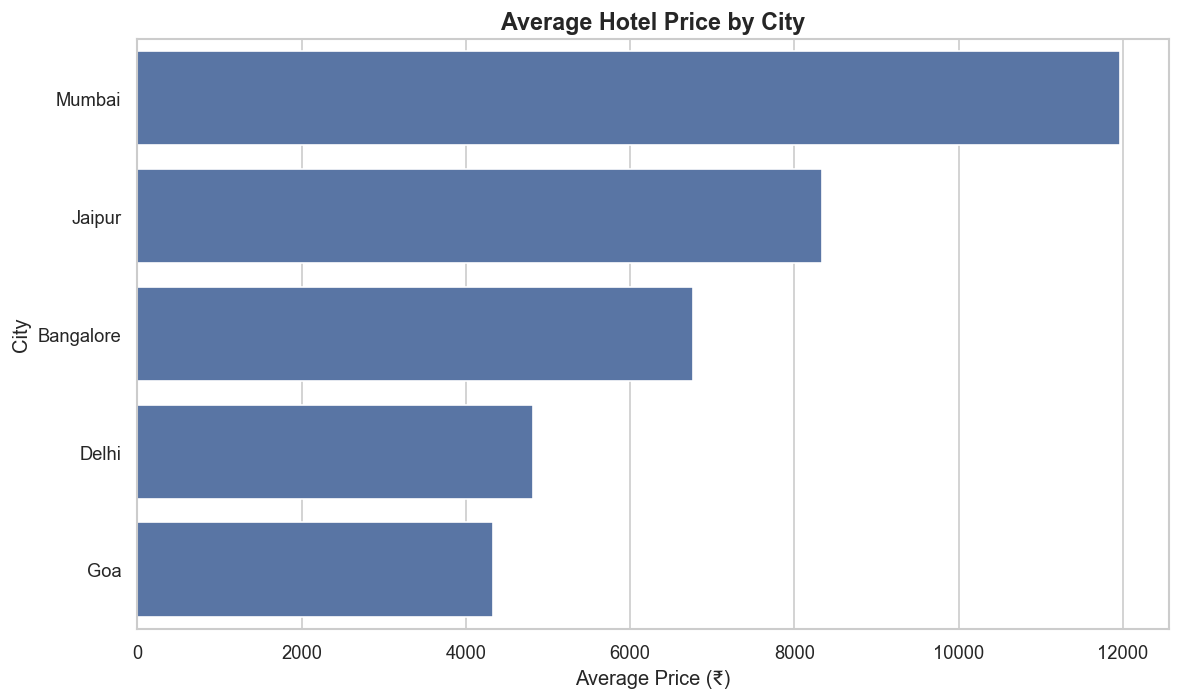

In [53]:
# Average Hotel Price by City
plt.figure(figsize=(10, 6))

avg_price_city = (
    df.groupby("city")["price"]
    .mean()
    .sort_values(ascending=False)
)

sns.barplot(
    x=avg_price_city.values,
    y=avg_price_city.index
)

plt.title("Average Hotel Price by City", fontsize=14, weight="bold")
plt.xlabel("Average Price (₹)")
plt.ylabel("City")

plt.tight_layout()
plt.show()

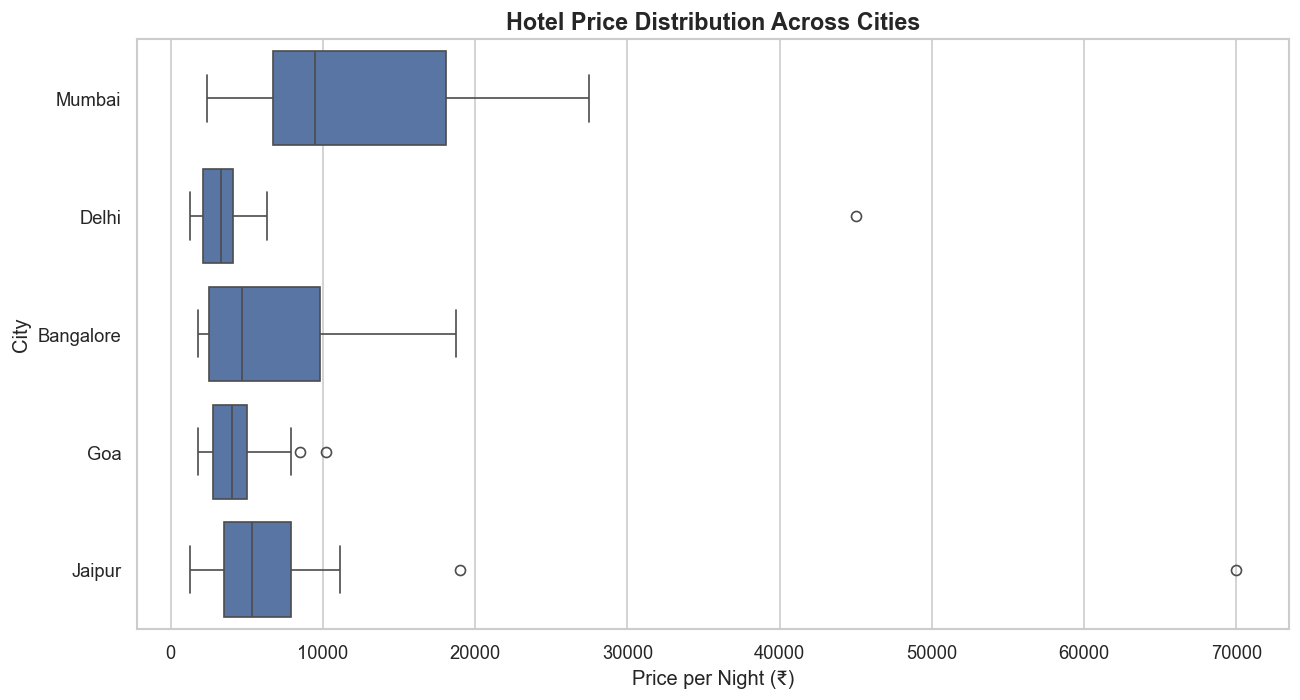

In [54]:
#  Price Distribution by City
plt.figure(figsize=(11, 6))

sns.boxplot(
    data=df,
    x="price",
    y="city"
)

plt.title("Hotel Price Distribution Across Cities", fontsize=14, weight="bold")
plt.xlabel("Price per Night (₹)")
plt.ylabel("City")

plt.tight_layout()
plt.show()

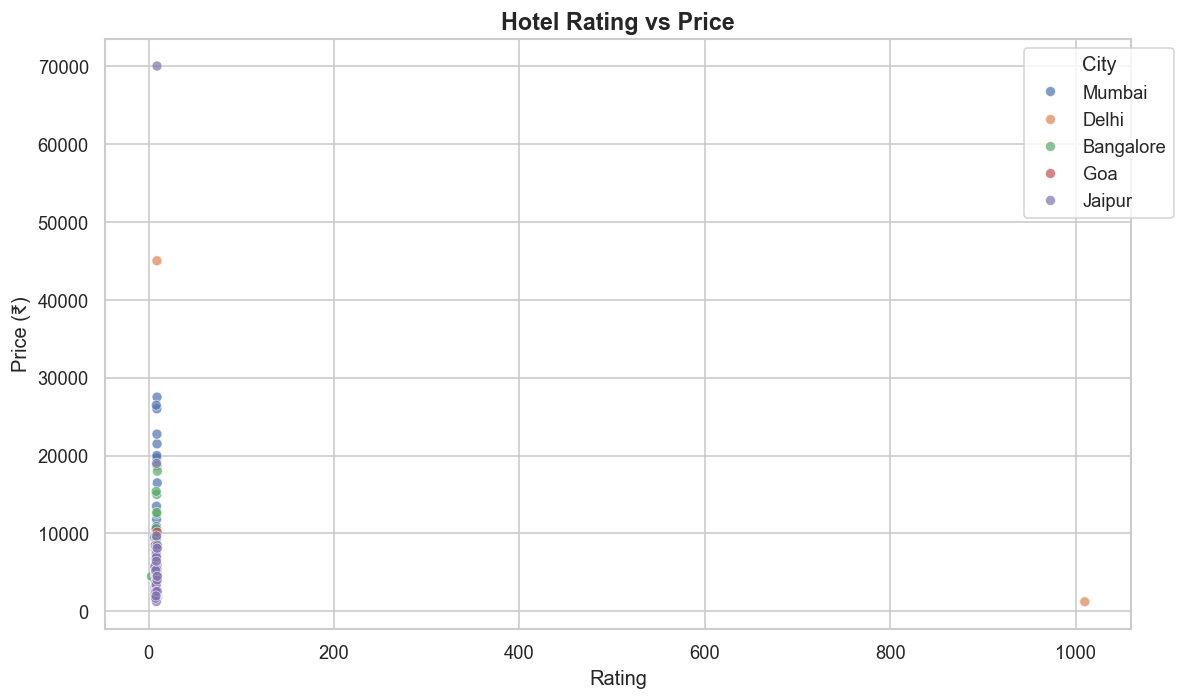

In [55]:
# Rating vs Price Relationship
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df,
    x="rating",
    y="price",
    hue="city",
    alpha=0.7
)

plt.title("Hotel Rating vs Price", fontsize=14, weight="bold")
plt.xlabel("Rating")
plt.ylabel("Price (₹)")

plt.legend(title="City", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

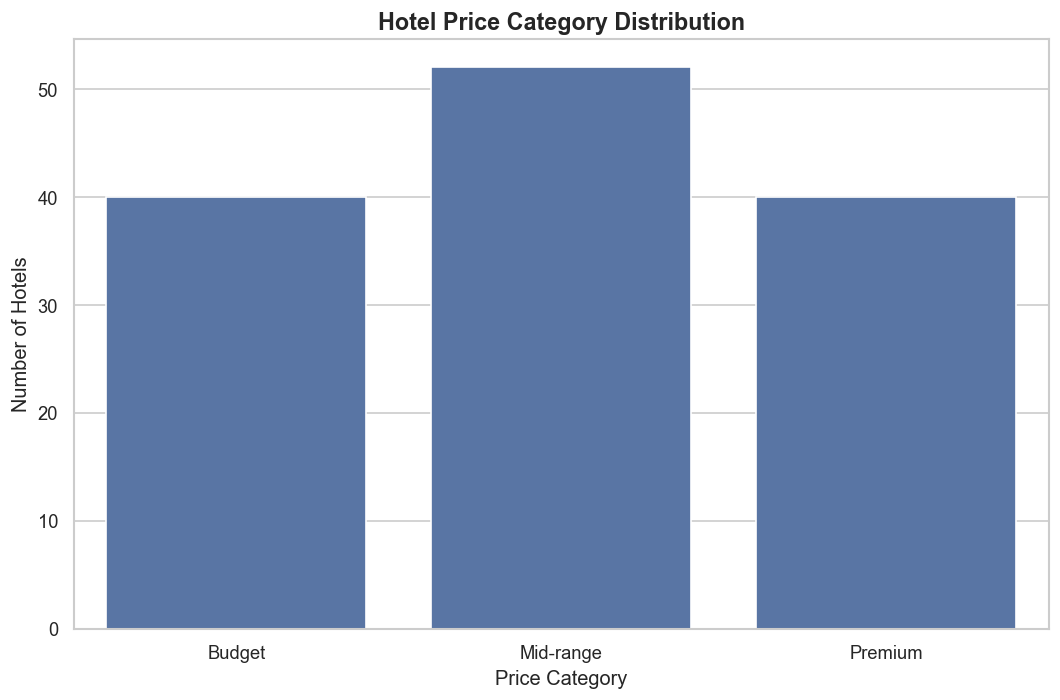

In [56]:
# Budget vs Mid-range vs Premium
plt.figure(figsize=(9, 6))

sns.countplot(
    data=df,
    x="price_category",
    order=["Budget", "Mid-range", "Premium"]
)

plt.title("Hotel Price Category Distribution", fontsize=14, weight="bold")
plt.xlabel("Price Category")
plt.ylabel("Number of Hotels")

plt.tight_layout()
plt.show()

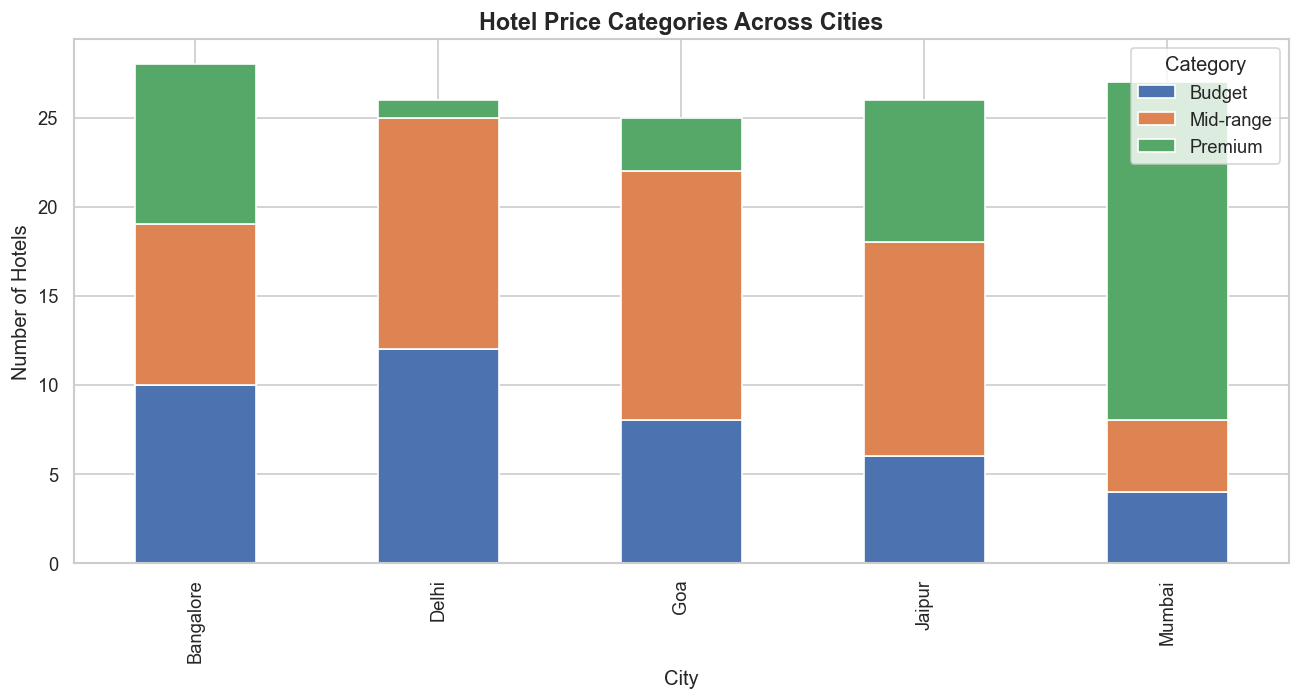

In [57]:
# City vs Price Category
pivot = pd.crosstab(df["city"], df["price_category"])

pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(11, 6)
)

plt.title("Hotel Price Categories Across Cities", fontsize=14, weight="bold")
plt.xlabel("City")
plt.ylabel("Number of Hotels")
plt.legend(title="Category")

plt.tight_layout()
plt.show()

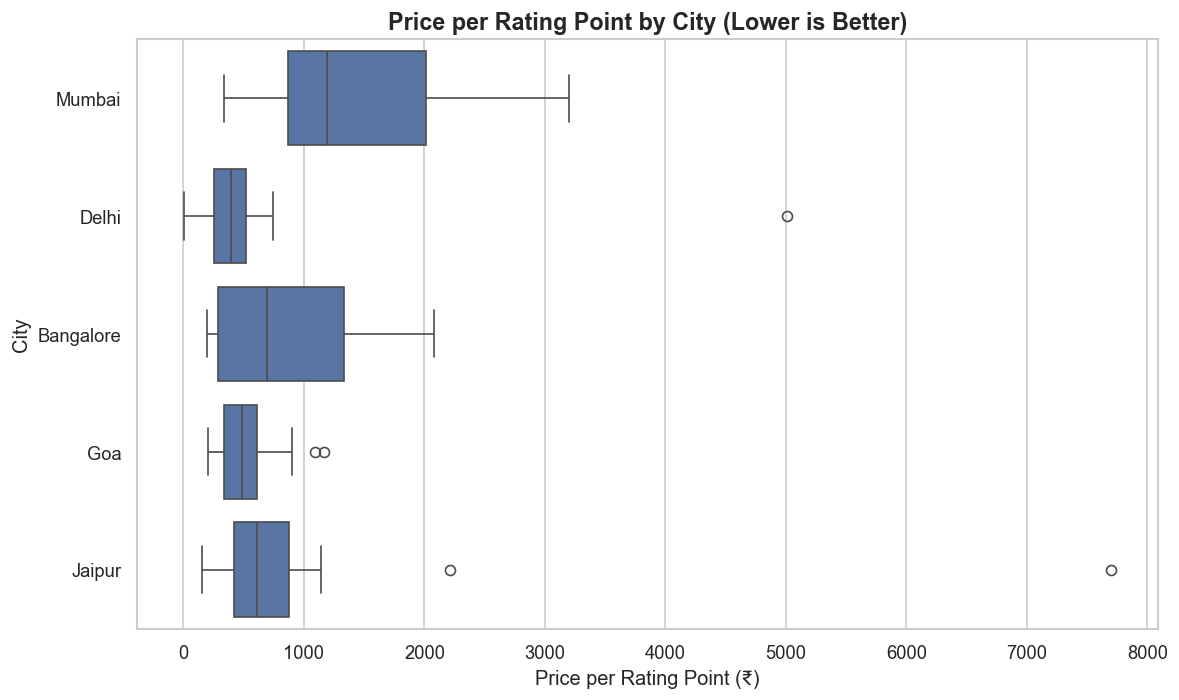

In [58]:
# Undervalued Hotels Insight
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df,
    x="price_per_rating",
    y="city"
)

plt.title("Price per Rating Point by City (Lower is Better)", fontsize=14, weight="bold")
plt.xlabel("Price per Rating Point (₹)")
plt.ylabel("City")

plt.tight_layout()
plt.show()

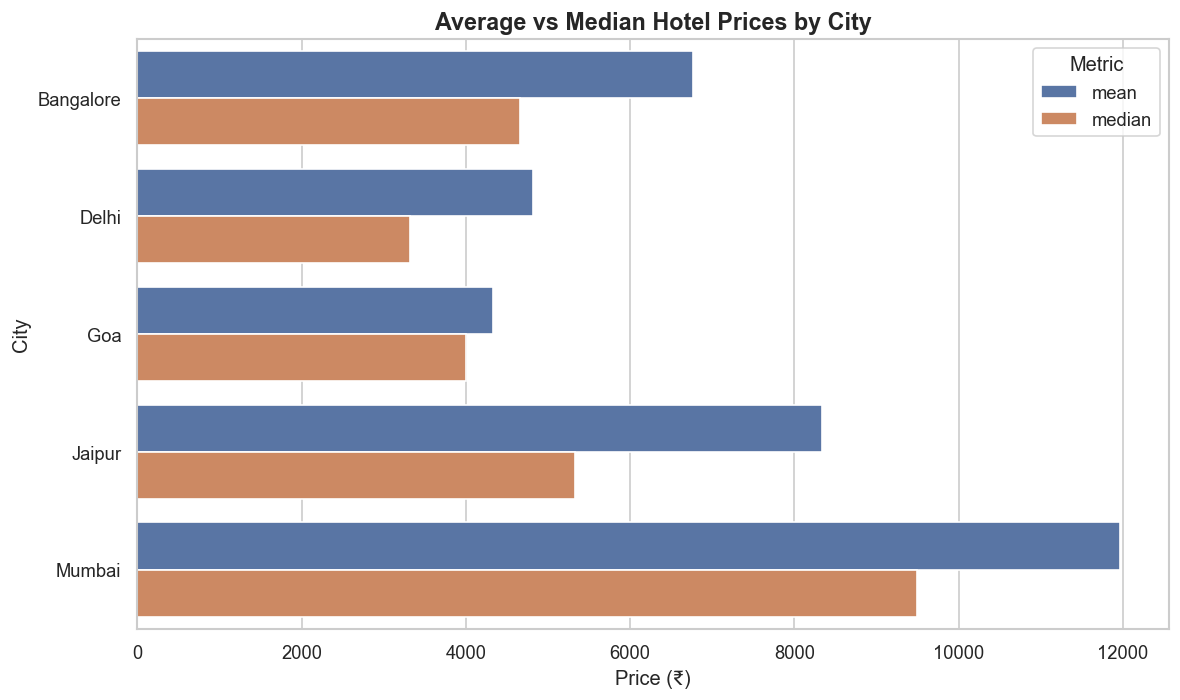

In [59]:
# Median Price vs Average Price by City
price_stats = df.groupby("city")["price"].agg(["mean", "median"]).reset_index()

price_stats_melted = price_stats.melt(
    id_vars="city",
    value_vars=["mean", "median"],
    var_name="Metric",
    value_name="Price"
)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=price_stats_melted,
    x="Price",
    y="city",
    hue="Metric"
)

plt.title("Average vs Median Hotel Prices by City", fontsize=14, weight="bold")
plt.xlabel("Price (₹)")
plt.ylabel("City")

plt.tight_layout()
plt.show()

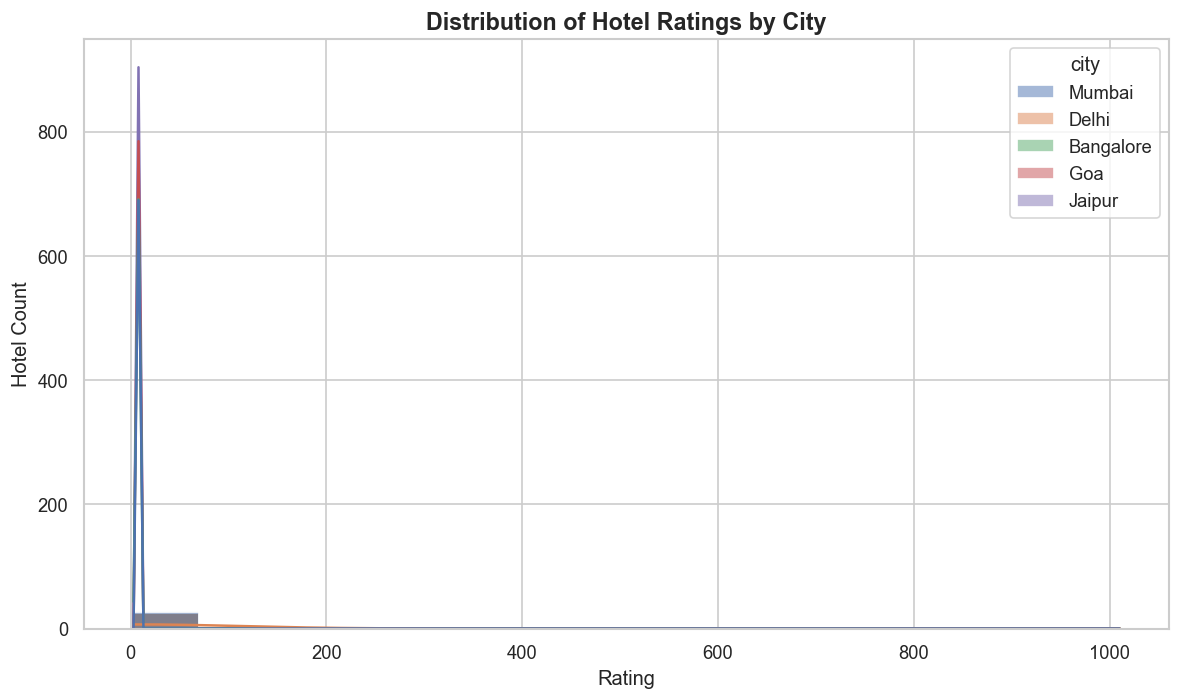

In [60]:
# Rating Distribution by City
plt.figure(figsize=(10, 6))

sns.histplot(
    data=df,
    x="rating",
    hue="city",
    bins=15,
    kde=True,
    alpha=0.5
)

plt.title("Distribution of Hotel Ratings by City", fontsize=14, weight="bold")
plt.xlabel("Rating")
plt.ylabel("Hotel Count")

plt.tight_layout()
plt.show()

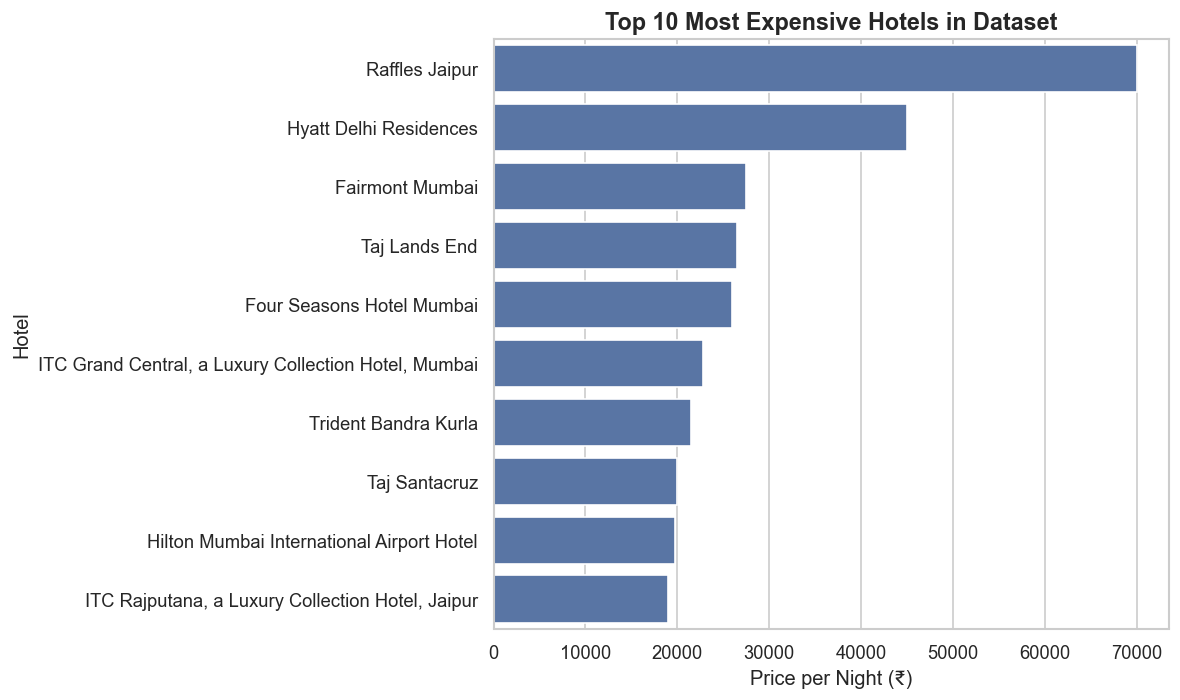

In [61]:
# Top 10 Most Expensive Hotels
top_expensive = df.sort_values("price", ascending=False).head(10)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=top_expensive,
    x="price",
    y="hotel_name"
)

plt.title("Top 10 Most Expensive Hotels in Dataset", fontsize=14, weight="bold")
plt.xlabel("Price per Night (₹)")
plt.ylabel("Hotel")

plt.tight_layout()
plt.show()

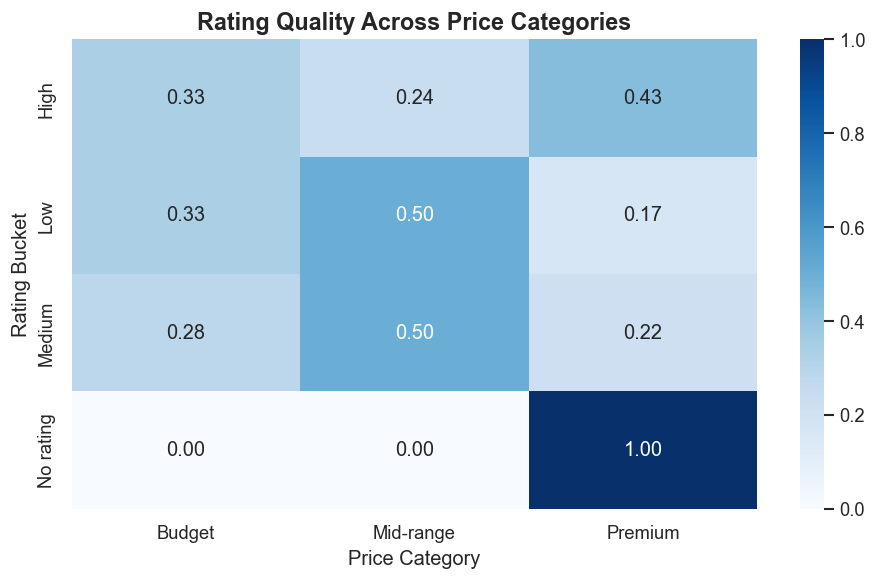

In [62]:
# Rating Bucket vs Price Category
heatmap_data = pd.crosstab(
    df["rating_bucket"],
    df["price_category"],
    normalize="index"
)

plt.figure(figsize=(8, 5))

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="Blues"
)

plt.title("Rating Quality Across Price Categories", fontsize=14, weight="bold")
plt.xlabel("Price Category")
plt.ylabel("Rating Bucket")

plt.tight_layout()
plt.show()

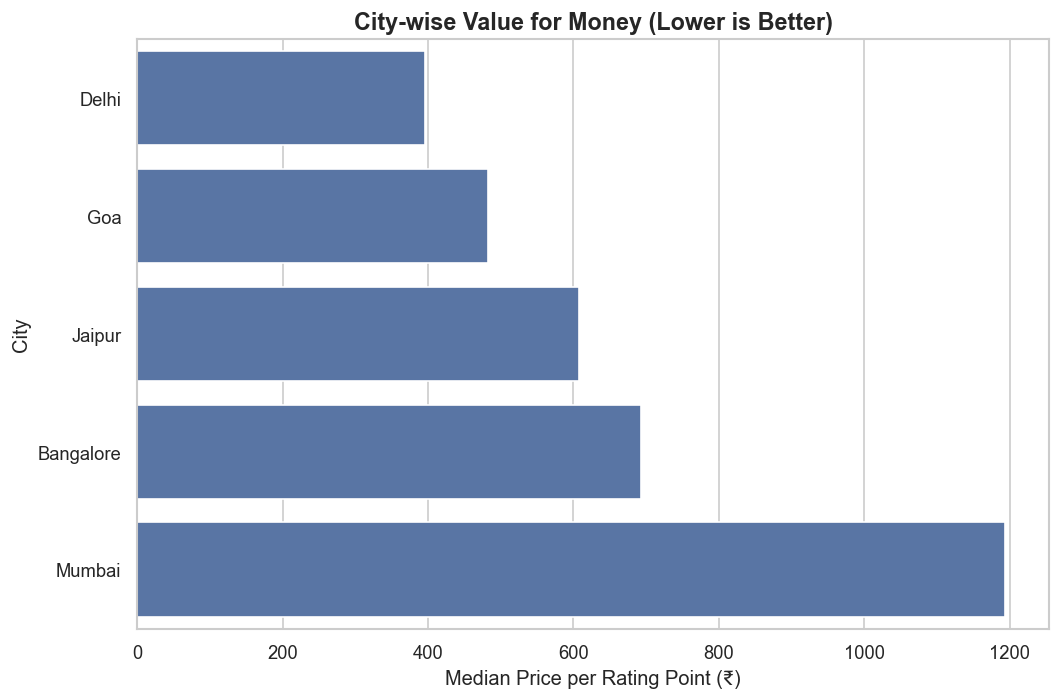

In [63]:
# Value-for-Money Ranking by City
value_city = (
    df.groupby("city")["price_per_rating"]
    .median()
    .sort_values()
)

plt.figure(figsize=(9, 6))

sns.barplot(
    x=value_city.values,
    y=value_city.index
)

plt.title("City-wise Value for Money (Lower is Better)", fontsize=14, weight="bold")
plt.xlabel("Median Price per Rating Point (₹)")
plt.ylabel("City")

plt.tight_layout()
plt.show()

In [64]:
final_df.to_csv("data/cleaned/booking_hotels_clean.csv", index=False)

In [65]:
import os
os.makedirs("data/cleaned", exist_ok=True)

final_df.to_csv("data/cleaned/booking_hotels_clean.csv", index=False)

In [66]:
import os
os.listdir("data/cleaned")

['booking_hotels_clean.csv']

In [67]:
import os
print(os.getcwd())

C:\Users\hp


In [68]:
os.path.exists("data")

True

In [69]:
os.path.exists("data/cleaned")

True

In [70]:
import os
import pandas as pd

# reload cleaned dataframe if needed
df = pd.read_csv("data/raw/booking_hotels_raw.csv")

# TEMP simple save to test
os.makedirs("data/cleaned", exist_ok=True)

df.to_csv("data/cleaned/TEST_FILE.csv", index=False)

print("Files in data/cleaned:")
print(os.listdir("data/cleaned"))

Files in data/cleaned:
['booking_hotels_clean.csv', 'TEST_FILE.csv']


In [71]:
import os
print("Current working directory:")
print(os.getcwd())

Current working directory:
C:\Users\hp


In [72]:
import os
import pandas as pd

# Load cleaned data again (safe)
df = pd.read_csv("data/raw/booking_hotels_raw.csv")

# Get notebook directory
notebook_dir = os.getcwd()

# Save CSV directly here
output_path = os.path.join(notebook_dir, "booking_hotels_clean.csv")

df.to_csv(output_path, index=False)

print("CSV saved at:")
print(output_path)

CSV saved at:
C:\Users\hp\booking_hotels_clean.csv


In [73]:
import pandas as pd

df = pd.read_csv("booking_hotels_clean.csv")

print(df.info())
print(df.head())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   city           264 non-null    object 
 1   hotel_name     264 non-null    object 
 2   price_raw      264 non-null    object 
 3   rating_raw     262 non-null    object 
 4   reviews_raw    262 non-null    float64
 5   property_type  0 non-null      float64
dtypes: float64(2), object(4)
memory usage: 12.5+ KB
None
     city                                      hotel_name price_raw  \
0  Mumbai  Hilton Garden Inn Mumbai International Airport  ₹ 10,007   
1  Mumbai                                 Fairmont Mumbai  ₹ 27,500   
2  Mumbai                        Hotel Bawa International   ₹ 6,750   
3  Mumbai       Hilton Mumbai International Airport Hotel  ₹ 19,700   
4  Mumbai                           Ginger Mumbai Airport   ₹ 7,999   

                            rating_raw  reviews_raw  proper

In [76]:
import pandas as pd
import numpy as np
import re
import os

# LOAD RAW DATA (correct path)
df = pd.read_csv("data/raw/booking_hotels_raw.csv")

# DROP USELESS COLUMN
df = df.drop(columns=["property_type"])

# CLEAN PRICE
def clean_price(price):
    price = re.sub(r"[^\d]", "", str(price))
    return float(price) if price else np.nan

df["price"] = df["price_raw"].apply(clean_price)

# CLEAN RATING
def clean_rating(text):
    match = re.search(r"\d+\.\d", str(text))
    return float(match.group()) if match else np.nan

df["rating"] = df["rating_raw"].apply(clean_rating)

# DROP RAW COLUMNS
df = df.drop(columns=["price_raw", "rating_raw", "reviews_raw"])

# DROP MISSING PRICE
df = df.dropna(subset=["price"])

# REMOVE DUPLICATES
df = df.drop_duplicates(subset=["city", "hotel_name", "price"])

# PRICE CATEGORY
def price_category(p):
    if p < 3000:
        return "Budget"
    elif p < 7000:
        return "Mid-range"
    else:
        return "Premium"

df["price_category"] = df["price"].apply(price_category)

# RATING BUCKET
def rating_bucket(r):
    if pd.isna(r):
        return "No rating"
    elif r >= 8.5:
        return "High"
    elif r >= 7:
        return "Medium"
    else:
        return "Low"

df["rating_bucket"] = df["rating"].apply(rating_bucket)

# PRICE PER RATING
df["price_per_rating"] = df["price"] / df["rating"]

# SAVE CLEANED FILE NEXT TO NOTEBOOK
output_path = os.path.join(os.getcwd(), "booking_hotels_clean_.csv")
df.to_csv(output_path, index=False)

print("✅ CLEANED FILE SAVED AT:")
print(output_path)

print("\nFinal dataset:")
print(df.info())


✅ CLEANED FILE SAVED AT:
C:\Users\hp\booking_hotels_clean_.csv

Final dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, 0 to 237
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              132 non-null    object 
 1   hotel_name        132 non-null    object 
 2   price             132 non-null    float64
 3   rating            130 non-null    float64
 4   price_category    132 non-null    object 
 5   rating_bucket     132 non-null    object 
 6   price_per_rating  130 non-null    float64
dtypes: float64(3), object(4)
memory usage: 8.2+ KB
None
